In [136]:
import os
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Armazena as vendas realizadas

In [137]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)

,data,vendedor,produto,numero_vendas
0,2019-01-01,Lucimar Sasso,Microsoft Azure,11
1,2019-01-01,Lucimar Sasso,Pacote Office,8
2,2019-01-01,Lucimar Sasso,Power BI,8
3,2019-01-01,Mariane Flauzino,Microsoft Azure,9
4,2019-01-01,Mariane Flauzino,Pacote Office,5
5,2019-01-01,Mariane Flauzino,Power BI,9
6,2019-01-01,Mateus Alves,Microsoft Azure,1
7,2019-01-01,Mateus Alves,Pacote Office,13
8,2019-01-01,Mateus Alves,Power BI,11
9,2019-01-02,Mateus Alves,Power BI,9


Verificar se existe valore nullos e formato dos valores

In [138]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9861 entries, 0 to 9860
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data           9861 non-null   object
 1   vendedor       9861 non-null   object
 2   produto        9861 non-null   object
 3   numero_vendas  9861 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 308.3+ KB


Removendo os campos vendedor e produto

In [139]:
store_sales = store_sales.drop(['vendedor', 'produto'], axis=1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9861 entries, 0 to 9860
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data           9861 non-null   object
 1   numero_vendas  9861 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 154.2+ KB


Convertando o campo data de object para dateTime

In [140]:
store_sales['data'] = pd.to_datetime(store_sales['data'])
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9861 entries, 0 to 9860
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data           9861 non-null   datetime64[ns]
 1   numero_vendas  9861 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 154.2 KB


Agrupando o campo data por Mês e somando o nº de venda de cada mês

In [141]:
store_sales['data'] = store_sales['data'].dt.to_period('M')
monthly_sales = store_sales.groupby('data').sum().reset_index()

Converte o novo valor do campo data para timestamp

In [142]:
monthly_sales['data'] = monthly_sales['data'].dt.to_timestamp()
monthly_sales.head(10)

,data,numero_vendas
0,2019-01-01,2209
1,2019-02-01,2221
2,2019-03-01,2210
3,2019-04-01,2251
4,2019-05-01,2193
5,2019-06-01,2205
6,2019-07-01,2256
7,2019-08-01,2307
8,2019-09-01,2143
9,2019-10-01,2175


Visualizando

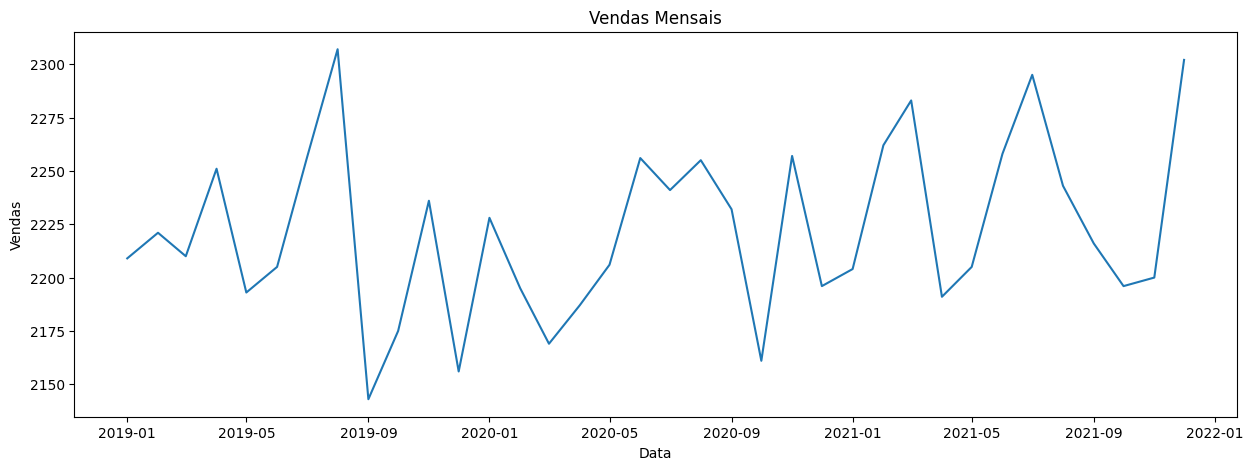

In [143]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['data'], monthly_sales['numero_vendas'])
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.title("Vendas Mensais")
plt.show()

Calculando a diferença de vendas entre os meses

In [144]:
monthly_sales['dif_vendas'] = monthly_sales['numero_vendas'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,data,numero_vendas,dif_vendas
1,2019-02-01,2221,12.0
2,2019-03-01,2210,-11.0
3,2019-04-01,2251,41.0
4,2019-05-01,2193,-58.0
5,2019-06-01,2205,12.0
6,2019-07-01,2256,51.0
7,2019-08-01,2307,51.0
8,2019-09-01,2143,-164.0
9,2019-10-01,2175,32.0
10,2019-11-01,2236,61.0


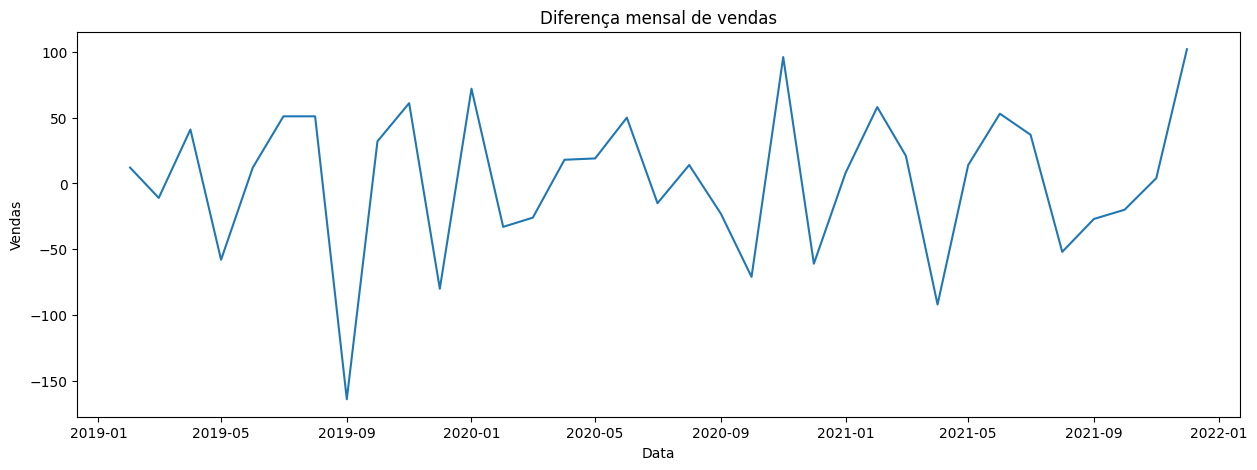

In [145]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['data'], monthly_sales['dif_vendas'])
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.title("Diferença mensal de vendas")
plt.show()

Removendo numero_vendas e data

In [146]:
supervised_data = monthly_sales.drop(['data', 'numero_vendas'], axis=1)

Preparando dados supervisionados

In [147]:
for i in range(1, 13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['dif_vendas'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,dif_vendas,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-33.0,72.0,-80.0,61.0,32.0,-164.0,51.0,51.0,12.0,-58.0,41.0,-11.0,12.0
1,-26.0,-33.0,72.0,-80.0,61.0,32.0,-164.0,51.0,51.0,12.0,-58.0,41.0,-11.0
2,18.0,-26.0,-33.0,72.0,-80.0,61.0,32.0,-164.0,51.0,51.0,12.0,-58.0,41.0
3,19.0,18.0,-26.0,-33.0,72.0,-80.0,61.0,32.0,-164.0,51.0,51.0,12.0,-58.0
4,50.0,19.0,18.0,-26.0,-33.0,72.0,-80.0,61.0,32.0,-164.0,51.0,51.0,12.0
5,-15.0,50.0,19.0,18.0,-26.0,-33.0,72.0,-80.0,61.0,32.0,-164.0,51.0,51.0
6,14.0,-15.0,50.0,19.0,18.0,-26.0,-33.0,72.0,-80.0,61.0,32.0,-164.0,51.0
7,-23.0,14.0,-15.0,50.0,19.0,18.0,-26.0,-33.0,72.0,-80.0,61.0,32.0,-164.0
8,-71.0,-23.0,14.0,-15.0,50.0,19.0,18.0,-26.0,-33.0,72.0,-80.0,61.0,32.0
9,96.0,-71.0,-23.0,14.0,-15.0,50.0,19.0,18.0,-26.0,-33.0,72.0,-80.0,61.0


Separar os dados entre dados de treino e teste

In [148]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (11, 13)
Test data shape:  (12, 13)


In [149]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [150]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (11, 12)
y_train shape:  (11,)
x_test shape:  (12, 12)
y_test shape:  (12,)


In [151]:
sales_date = monthly_sales['data'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_date)

In [152]:
act_sales = monthly_sales['numero_vendas'][-13:].to_list()
print(act_sales)

[2196, 2204, 2262, 2283, 2191, 2205, 2258, 2295, 2243, 2216, 2196, 2200, 2302]


Criando modelo de regressão linear

In [153]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [154]:
lr_pre = lr_pre.reshape(-1, 1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [155]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])

lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [156]:
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"], monthly_sales['numero_vendas'][-12:]))
lr_mae = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales['numero_vendas'][-12:])
lr_r2 = r2_score(predict_df["Linear Prediction"], monthly_sales['numero_vendas'][-12:])
print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  122.86342447961492
Linear Regression MAE:  103.61369297407965
Linear Regression R2:  -0.09936577285092296


Visualizando a previsão contro o valor atual de vendas

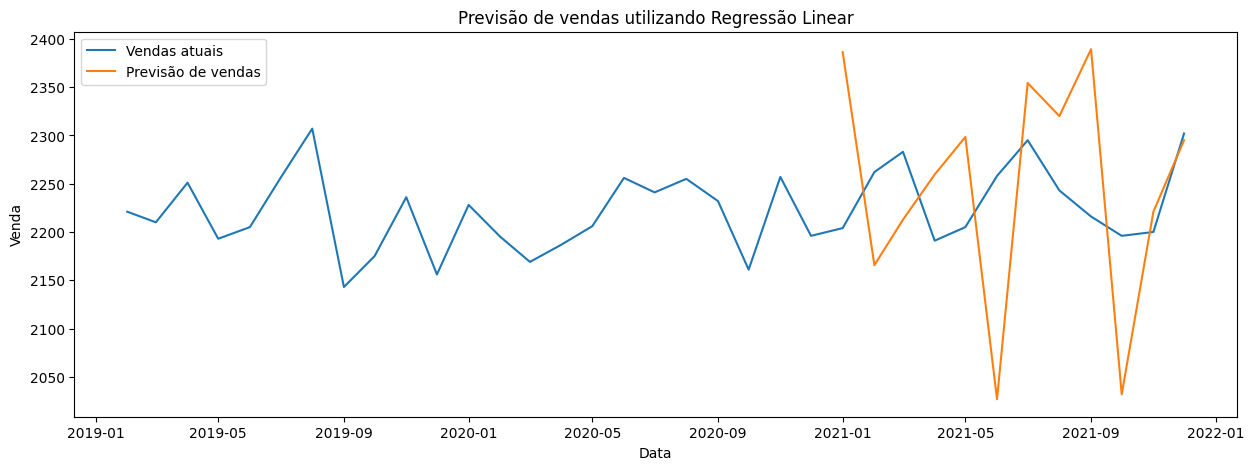

In [160]:
plt.figure(figsize=(15,5))

# Actual sales
plt.plot(monthly_sales['data'], monthly_sales['numero_vendas'])

# Predicted sales
plt.plot(predict_df['data'], predict_df['Linear Prediction'])

plt.title("Previsão de vendas utilizando Regressão Linear")
plt.xlabel("Data")
plt.ylabel("Venda")
plt.legend(["Vendas atuais", "Previsão de vendas"])
plt.show()